# Fragmentación de texto con base en el contexto

Una vez que se ha extraído el texto de un documento, es posible que se requiera dividirlo en fragmentos más pequeños, como oraciones o palabras, para su posterior análisis. En este notebook se presentan algunas técnicas para realizar esta tarea con base en el contexto.

## Librerías

In [1]:
from functools import partial

import pandas as pd
import seaborn as sns
import tiktoken
from langchain.schema import Document
from langchain.text_splitter import (
    Language,
    MarkdownHeaderTextSplitter,
    RecursiveCharacterTextSplitter,
)

from src.langchain_docs_loader import LangchainDocsLoader

Utilizaremos la función `print_example_doc_splits_from_docs` a través de este notebook para imprimir el contenido de los documentos cuya metadata `source` coinsida con el valor proporcionado.

In [2]:
def print_example_doc_splits_from_docs(
    docs: list[Document],
    source: str,
) -> None:
    for doc in docs:
        if doc.metadata["source"] == source:
            print("\n")
            print(f" {doc.metadata['source']} ".center(80, "="))
            print("\n")
            print(doc.page_content)


print_split_for_lcle = partial(
    print_example_doc_splits_from_docs,
    source="https://python.langchain.com/docs/expression_language/interface",
)

## Carga de datos

De aquí en adelante, utilizaremos el conjunto de documentos extraídos en el notebook [01_context_aware_text_extraction.ipynb](01_context_aware_text_extraction.ipynb).

In [3]:
loader = LangchainDocsLoader(include_output_cells=True)
docs = loader.load()
f"Loaded {len(docs)} documents"

'Loaded 962 documents'

## Fragmentación de texto sin tener en cuenta el contexto

La forma más sencilla de fragmentar texto es utilizando la función `split` de Python. Esta función recibe como parámetro un caracter o cadena de caracteres que se utilizará como separador. Por ejemplo, para fragmentar un texto en oraciones, se puede utilizar el caracter `.` como separador.

Sin embargo, podemos ir un poco más allá y utilizar `RecursiveCharacterTextSplitter()` de langchain para dividir texto observando caracteres de forma recursiva. Esta herramienta intenta, de manera recursiva, dividir el texto por diferentes caracteres para encontrar uno que funcione, permitiendo así una fragmentación de texto más precisa y adaptable a diferentes contextos y formatos de texto, aunque no tenga en cuenta el contexto semántico del mismo.

In [4]:
text_splitter_without_context = RecursiveCharacterTextSplitter()

splitted_documents_without_context = text_splitter_without_context.split_documents(docs)
print_split_for_lcle(splitted_documents_without_context)



======= https://python.langchain.com/docs/expression_language/interface ========


# Interface

In an effort to make it as easy as possible to create custom chains, we've implemented a ["Runnable"](https://api.python.langchain.com/en/latest/schema/langchain.schema.runnable.Runnable.html#langchain.schema.runnable.Runnable) protocol that most components implement. This is a standard interface with a few different methods, which makes it easy to define custom chains as well as making it possible to invoke them in a standard way. The standard interface exposed includes:

- `stream`: stream back chunks of the response
- `invoke`: call the chain on an input
- `batch`: call the chain on a list of inputs

These also have corresponding async methods:

- `astream`: stream back chunks of the response async
- `ainvoke`: call the chain on an input async
- `abatch`: call the chain on a list of inputs async

The type of the input varies by component:

| Component | Input Type |
| ---- | ---- |
| Pr

## Framentación de texto con contexto de distrubución de `tokens`

En muchas ocasiones, el contexto de cómo se distribuyen los `tokens` o `caracteres` en el texto puede ser de gran ayuda para decidir cómo fragmentar el texto. Veámoslo con un ejemplo.


### Funciones de apoyo

In [5]:
def num_tokens_from_string(string: str, encoding_name: str = "cl100k_base") -> int:
    """Returns the number of tokens in a text string."""
    encoding = tiktoken.get_encoding(encoding_name)
    num_tokens = len(encoding.encode(string))
    return num_tokens


def num_tokens_from_document(
    document: Document, encoding_name: str = "cl100k_base"
) -> int:
    """Returns the number of tokens in a document."""
    return num_tokens_from_string(document.page_content, encoding_name)

### Estadísticas de tokens en los textos

Calculemos algunas estadísticas de los `tokens` en los textos utilizado `pandas`.

In [6]:
tokens_per_document = pd.Series([num_tokens_from_document(doc) for doc in docs])
tokens_per_document.describe()

count      962.000000
mean      1599.195426
std       3419.855171
min         42.000000
25%        382.250000
50%        809.500000
75%       1646.750000
max      80983.000000
dtype: float64

La amplia variabilidad en el número de tokens por documento sugiere que se está tratando con documentos de longitudes muy diversas, desde muy cortos hasta muy largos. Esto podría afectar a los análisis subsiguientes y debería tenerse en cuenta al desarrollar modelos de procesamiento de lenguaje natural, ajustando posiblemente los métodos de preprocesamiento o utilizando técnicas que puedan manejar eficientemente documentos de diferentes longitudes. Además, el sesgo a la derecha en la distribución sugiere que aunque la mayoría de los documentos son relativamente cortos, hay algunos documentos extremadamente largos que podrían ser atípicos y necesitar un tratamiento especial.

### Visualización de distribución de tokens sin outliers

[Text(0.5, 0, 'Number of tokens'),
 Text(0, 0.5, 'Number of documents'),
 Text(0.5, 1.0, 'Number of tokens per document')]

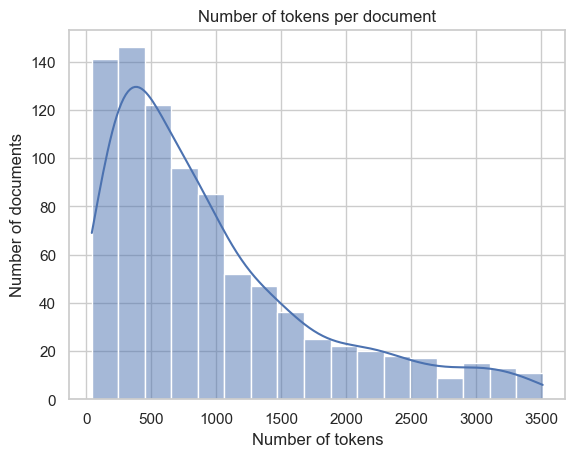

In [7]:
# Calculate Q1, Q3, and IQR
Q1 = tokens_per_document.quantile(0.25)
Q3 = tokens_per_document.quantile(0.75)
IQR = Q3 - Q1

upper_bound = Q3 + 1.5 * IQR

# We only filter outliers by upper bound since we don't have problems with short documents.
filtered_tokens = tokens_per_document[(tokens_per_document <= upper_bound)]

# Plot the important sections of the histogram
sns.set_theme(style="whitegrid")
fig = sns.histplot(filtered_tokens, kde=True)
fig.set(
    xlabel="Number of tokens",
    ylabel="Number of documents",
    title="Number of tokens per document",
)

### Framentación de texto con base en la distribución de tokens

Considerando los resultados anteriores, podemos utilizar la información de la distribución de tokens para fragmentar el texto de forma más precisa. Para ello, utilizaremos la función `RecursiveCharacterTextSplitter()` de langchain, pero ahora especifícaremos los parámetros `chunk_size` y `chunk_overlap`.

In [8]:
splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=50,
    length_function=num_tokens_from_string,
)

splitted_with_little_context = splitter.split_documents(docs)
print_split_for_lcle(splitted_with_little_context)



======= https://python.langchain.com/docs/expression_language/interface ========


# Interface

In an effort to make it as easy as possible to create custom chains, we've implemented a ["Runnable"](https://api.python.langchain.com/en/latest/schema/langchain.schema.runnable.Runnable.html#langchain.schema.runnable.Runnable) protocol that most components implement. This is a standard interface with a few different methods, which makes it easy to define custom chains as well as making it possible to invoke them in a standard way. The standard interface exposed includes:

- `stream`: stream back chunks of the response
- `invoke`: call the chain on an input
- `batch`: call the chain on a list of inputs

These also have corresponding async methods:

- `astream`: stream back chunks of the response async
- `ainvoke`: call the chain on an input async
- `abatch`: call the chain on a list of inputs async

The type of the input varies by component:

| Component | Input Type |
| ---- | ---- |
| Pr

## Framentación de texto con contexto

Con el dominio del problema podemos fragmentar el texto de manera más precisa.

### Framentación de texto con base en una especificación de lenguaje como contexto

En nuestro ejemplo, nuestros documentos son `Markdown`, por lo que podríamos fragmentar el documento en función de los caracteres que se utilizan para definir los encabezados de las secciones y otros elementos de formato.

En este caso, la función internamente utiliza los siguientes patrones para fragmentar el texto:

```python
[
    # First, try to split along Markdown headings (starting with level 2)
    "\n#{1,6} ",
    # Note the alternative syntax for headings (below) is not handled here
    # Heading level 2
    # ---------------
    # End of code block
    "```\n",
    # Horizontal lines
    "\n\\*\\*\\*+\n",
    "\n---+\n",
    "\n___+\n",
    # Note that this splitter doesn't handle horizontal lines defined
    # by *three or more* of ***, ---, or ___, but this is not handled
    "\n\n",
    "\n",
    " ",
    "",
]
```

In [9]:
md_language_splitter = RecursiveCharacterTextSplitter.from_language(
    language=Language.MARKDOWN,
    chunk_size=1000,
    chunk_overlap=50,
    length_function=num_tokens_from_string,
)
md_language_splits = md_language_splitter.split_documents(docs)
print_split_for_lcle(md_language_splits)



======= https://python.langchain.com/docs/expression_language/interface ========


# Interface

In an effort to make it as easy as possible to create custom chains, we've implemented a ["Runnable"](https://api.python.langchain.com/en/latest/schema/langchain.schema.runnable.Runnable.html#langchain.schema.runnable.Runnable) protocol that most components implement. This is a standard interface with a few different methods, which makes it easy to define custom chains as well as making it possible to invoke them in a standard way. The standard interface exposed includes:

- `stream`: stream back chunks of the response
- `invoke`: call the chain on an input
- `batch`: call the chain on a list of inputs

These also have corresponding async methods:

- `astream`: stream back chunks of the response async
- `ainvoke`: call the chain on an input async
- `abatch`: call the chain on a list of inputs async

The type of the input varies by component:

| Component | Input Type |
| ---- | ---- |
| Pr

### Framentación de texto utilizando encabezados como contexto

En contrastraste con el ejemplo anterior, en este caso utilizaremos únicamente los encabezados de los documentos como contexto para fragmentar el texto. Estos encabezados pasarán a formar parte de los meta-datos de los fragmentos.

Dentro de cada framento de encabezado, podríamos repetir el proceso de fragmentación de texto con base en la distribución de tokens o en una especificación de lenguaje como contexto.

In [10]:
md_headers_splits: list[Document] = []

for doc in docs:
    md_header_splitter = MarkdownHeaderTextSplitter(
        headers_to_split_on=[
            ("#", "Header 1"),
            ("##", "Header 2"),
        ]
    )
    text_splitter = RecursiveCharacterTextSplitter.from_language(
        language=Language.MARKDOWN,
        chunk_size=1000,  # try then with 150
        chunk_overlap=50,
        length_function=num_tokens_from_string,
    )

    splits = md_header_splitter.split_text(doc.page_content)

    splits = text_splitter.split_documents(splits)
    splits = [
        Document(
            page_content=split.page_content,
            metadata={
                **split.metadata,
                **doc.metadata,
            },
        )
        for split in splits
    ]
    md_headers_splits.extend(splits)

print_split_for_lcle(md_headers_splits)



======= https://python.langchain.com/docs/expression_language/interface ========


In an effort to make it as easy as possible to create custom chains, we've implemented a ["Runnable"](https://api.python.langchain.com/en/latest/schema/langchain.schema.runnable.Runnable.html#langchain.schema.runnable.Runnable) protocol that most components implement. This is a standard interface with a few different methods, which makes it easy to define custom chains as well as making it possible to invoke them in a standard way. The standard interface exposed includes:  
- `stream`: stream back chunks of the response
- `invoke`: call the chain on an input
- `batch`: call the chain on a list of inputs  
These also have corresponding async methods:  
- `astream`: stream back chunks of the response async
- `ainvoke`: call the chain on an input async
- `abatch`: call the chain on a list of inputs async  
The type of the input varies by component:  
| Component | Input Type |
| ---- | ---- |
| Prompt | D